In [323]:
!pip install -q efficientnet

In [324]:
# loading packages

import pandas as pd
import numpy as np

#

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

#

import seaborn as sns
import plotly.express as px

#

import os
import random
import re
import math
import time

from tqdm import tqdm
from tqdm.keras import TqdmCallback


from pandas_summary import DataFrameSummary

import warnings


warnings.filterwarnings('ignore') # Disabling warnings for clearer outputs



seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)


import numpy as np
import pandas as pd
import os
import random, re, math, time
random.seed(a=128)

from os.path import join 

import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_addons as tfa
import efficientnet.tfkeras as efn

from tqdm.keras import TqdmCallback

from PIL import Image
import PIL

import matplotlib.pyplot as plt

from sklearn.model_selection import KFold

from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from pandas_summary import DataFrameSummary

from kaggle_datasets import KaggleDatasets

from tqdm import tqdm

In [325]:
# Setting color palette.
orange_black = [
    '#fdc029', '#df861d', '#FF6347', '#aa3d01', '#a30e15', '#800000', '#171820'
]

We set some custom styling with our notebook for aesthetics...

In [326]:
print(os.listdir("../input"))



['melanoma2020imgtabular', 'melanoma-384x384', 'siim-isic-melanoma-classification', 'image-names', 'melanoma-128x128']


In [327]:
# Setting file paths for our notebook:

base_path = '/kaggle/input/siim-isic-melanoma-classification'
train_img_path = '/kaggle/input/siim-isic-melanoma-classification/jpeg/train/'
test_img_path = '/kaggle/input/siim-isic-melanoma-classification/jpeg/test/'
img_stats_path = '/kaggle/input/melanoma2020imgtabular'

# Loading the Data

We'll continue by loading metadata we're given. Train data has 8 features, 33126 observations and Test data 5 features, 10982 observations.

#### Train Dataset Consists Of:

1. image name -> the filename of specific image for the train set
2. patient_id -> identifies the unique patient
3. sex -> gender of the patient
4. age_approx -> approx age of the patient at time of scanning
5. anatom_site_general_challenge -> location of the scan site
6. diagnosis -> information about the diagnosis
7. benign_malignant - indicates scan result if it's malignant or benign
8. target -> same as above but better for modelling since it's binary

And the next dataset we going to inspect test. It has same features as train set except for scan results, well that's why it's test set right?!

#### Test Dataset Consists Of:

1. image name -> the filename of specific image for the train set
2. patient_id -> identifies the unique patient
3. sex -> gender of the patient
4. age_approx -> approx age of the patient at time of scanning
5. anatom_site_general_challenge -> location of the scan site

In [328]:
# Loading train and test data.

train = pd.read_csv(os.path.join(base_path, 'train.csv'))
test = pd.read_csv(os.path.join(base_path, 'test.csv'))
sample = pd.read_csv(os.path.join(base_path, 'sample_submission.csv'))

In [329]:
# Checking train and test columns/rows.

print(
    f'Train data has {train.shape[1]} features, {train.shape[0]} observations and Test data {test.shape[1]} features, {test.shape[0]} observations.\nTrain features are:\n{train.columns.tolist()}\nTest features are:\n{test.columns.tolist()}'
)

Train data has 8 features, 33126 observations and Test data 5 features, 10982 observations.
Train features are:
['image_name', 'patient_id', 'sex', 'age_approx', 'anatom_site_general_challenge', 'diagnosis', 'benign_malignant', 'target']
Test features are:
['image_name', 'patient_id', 'sex', 'age_approx', 'anatom_site_general_challenge']


In [330]:
# Renaming train/test columns:

train.columns = [
    'img_name', 'id', 'sex', 'age', 'location', 'diagnosis',
    'benign_malignant', 'target'
]
test.columns = ['img_name', 'id', 'sex', 'age', 'location']

# Missing Values

We have small portion of missing values for age and sex I think there is no harm if we impute them with the most frequent ones, meanwhile body parts missing on both datasets, we better be set 'unknown' for missing values for this one...

# Imputing Missing Data

Let's fill the missing values with appropriate methods.

In [331]:
# Filling missing anatom site values with 'unknown' tag:

for df in [train, test]:
    df['location'].fillna('unknown', inplace=True)

In [332]:
# Double checking:

ids_train = train.location.values
ids_test = test.location.values
ids_train_set = set(ids_train)
ids_test_set = set(ids_test)

location_not_overlap = list(ids_train_set.symmetric_difference(ids_test_set))
n_overlap = len(location_not_overlap)
if n_overlap == 0:
    print(
        f'There are no different body parts occuring between train and test set...'
    )
else:
    print('There are some not overlapping values between train and test set!')

There are no different body parts occuring between train and test set...


In [333]:
# Filling age and sex with appropriate values.

train['sex'].fillna(train['sex'].mode()[0], inplace=True)

train['age'].fillna(train['age'].median(), inplace=True)

In [334]:
# Checking missing value counts:

print(
    f'Train missing value count: {train.isnull().sum().sum()}\nTest missing value count: {train.isnull().sum().sum()}'
)

Train missing value count: 0
Test missing value count: 0


In [335]:
train['age_min'] = train['id'].map(train.groupby(['id']).age.min())
train['age_max'] = train['id'].map(train.groupby(['id']).age.max())

test['age_min'] = test['id'].map(test.groupby(['id']).age.min())
test['age_max'] = test['id'].map(test.groupby(['id']).age.max())

In [336]:
train['n_images'] = train.id.map(train.groupby(['id']).img_name.count())
test['n_images'] = test.id.map(test.groupby(['id']).img_name.count())

# Loading Image Meta Features

This is the part where we get basic info directly from images themselves.

In [337]:
# Getting image sizes by using os:

for data, location in zip([train, test], [train_img_path, test_img_path]):
    images = data['img_name'].values
    sizes = np.zeros(images.shape[0])
    for i, path in enumerate(tqdm(images)):
        sizes[i] = os.path.getsize(os.path.join(location, f'{path}.jpg'))

    data['image_size'] = sizes

100%|██████████| 10982/10982 [00:08<00:00, 1280.16it/s]


# Image Sizes

We can see some kind of relation between size and target, but is it meaningful? Too soon to say...

In [338]:
# Loading color data:

train_attr = pd.read_csv(
    os.path.join(img_stats_path, 'train_mean_colorres.csv'))
test_attr = pd.read_csv(os.path.join(img_stats_path, 'test_mean_colorres.csv'))

In [339]:
train_attr.head()

,reds,greens,blues,mean_colors,width,height,total_pixels
0,212.935898,138.914175,157.742255,169.864109,6000,4000,24000000
1,217.292550,165.093667,130.881285,171.089167,6000,4000,24000000
2,199.941121,130.227057,145.908743,158.692307,1872,1053,1971216
3,119.690968,62.614725,58.724976,80.343556,1872,1053,1971216
4,226.279244,173.174914,152.425131,183.959763,6000,4000,24000000


In [340]:
train = pd.concat([train, train_attr], axis=1)
test = pd.concat([test, test_attr], axis=1)

train['res'] = train['width'].astype(str) + 'x' + train['height'].astype(str)
test['res'] = test['width'].astype(str) + 'x' + test['height'].astype(str)

# Correlations Between Features

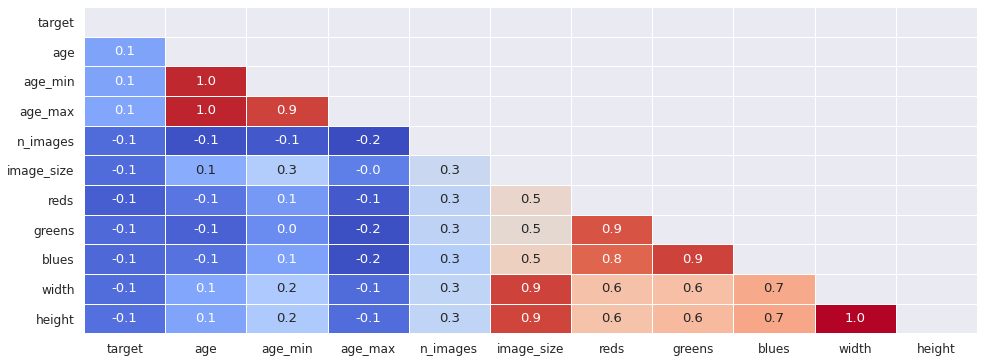

In [341]:
# Display numerical correlations between features on heatmap.

sns.set(font_scale=1.1)
correlation_train = train[['target','age','age_min',
 'age_max',
 'n_images',
 'image_size',
 'reds',
 'greens',
 'blues', 
 'width',
 'height',
 ]].corr()
mask = np.triu(correlation_train.corr())
plt.figure(figsize=(16, 6))
sns.heatmap(correlation_train,
            annot=True,
            fmt='.1f',
            cmap='coolwarm',            
            mask=mask,
            linewidths=1,
            cbar=False)

plt.show()



# Modelling Based on Tabular Meta Features

## Getting Landscape Attributes from Images

Thanks to this great dataset by Marcelo Kittlein [here.](https://www.kaggle.com/kittlein/landscape)

In [342]:
# load image names and rename column to match train
image_names_df = pd.read_csv('../input/image-names/Image_Names.csv')
image_names_df.columns = ['img_name']


In [343]:
# Loading lanscape data

train40 = pd.read_csv('../input/melanoma2020imgtabular/train40Features.csv')
test40 = pd.read_csv('../input/melanoma2020imgtabular/test40Features.csv')

trainmet = pd.read_csv('../input/melanoma2020imgtabular/trainMetrics.csv')
testmet = pd.read_csv('../input/melanoma2020imgtabular/testMetrics.csv')

In [344]:

train40.columns

Index(['sex', 'age_approx', 'anatom_site_general_challenge', 'V1', 'V2', 'V3',
       'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14',
       'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24',
       'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34',
       'V35', 'V36', 'V37'],
      dtype='object')

In [345]:
# Dropping duplicate data from lanscape dataset

train40.drop(['sex', 'age_approx', 'anatom_site_general_challenge'],
             axis=1,
             inplace=True)

test40.drop(['sex', 'age_approx', 'anatom_site_general_challenge'],
            axis=1,
            inplace=True)

In [346]:
train40.columns = ['total_area','number_of_patches','patch_density','largest_patch_index','total_edge','edge_density','landscape_shape_index','effective_mesh_size','area_mn','area_am','area_md','area_ra','area_sd','area_cv','perimeter_mn','perimeter_am','perimeter_md','perimeter_ra','perimeter_sd','perimeter_cv','perimeter_area_ratio_mn','perimeter_area_ratio_am','perimeter_area_ratio_md','perimeter_area_ratio_ra','perimeter_area_ratio_sd','perimeter_area_ratio_cv','shape_index_mn','shape_index_am','shape_index_md','shape_index_ra','shape_index_sd','shape_index_cv','fractal_dimension_mn','fractal_dimension_ra','fractal_dimension_sd','contagion','shannon_diversity_index']
test40.columns = ['total_area','number_of_patches','patch_density','largest_patch_index','total_edge','edge_density','landscape_shape_index','effective_mesh_size','area_mn','area_am','area_md','area_ra','area_sd','area_cv','perimeter_mn','perimeter_am','perimeter_md','perimeter_ra','perimeter_sd','perimeter_cv','perimeter_area_ratio_mn','perimeter_area_ratio_am','perimeter_area_ratio_md','perimeter_area_ratio_ra','perimeter_area_ratio_sd','perimeter_area_ratio_cv','shape_index_mn','shape_index_am','shape_index_md','shape_index_ra','shape_index_sd','shape_index_cv','fractal_dimension_mn','fractal_dimension_ra','fractal_dimension_sd','contagion','shannon_diversity_index',]

In [347]:
# add images names to train40
train40 = pd.concat([image_names_df, train40], axis=1)

In [348]:
# merging both datasets

# train = pd.concat([train, train40, trainmet], axis=1)
#train = pd.concat([train, train40], axis=1)
train = pd.merge(train, train40, on='img_name')

# test = pd.concat([test, test40, testmet], axis=1)
test = pd.concat([test, test40], axis=1)

In [349]:
train.columns

Index(['img_name', 'id', 'sex', 'age', 'location', 'diagnosis',
       'benign_malignant', 'target', 'age_min', 'age_max', 'n_images',
       'image_size', 'reds', 'greens', 'blues', 'mean_colors', 'width',
       'height', 'total_pixels', 'res', 'total_area', 'number_of_patches',
       'patch_density', 'largest_patch_index', 'total_edge', 'edge_density',
       'landscape_shape_index', 'effective_mesh_size', 'area_mn', 'area_am',
       'area_md', 'area_ra', 'area_sd', 'area_cv', 'perimeter_mn',
       'perimeter_am', 'perimeter_md', 'perimeter_ra', 'perimeter_sd',
       'perimeter_cv', 'perimeter_area_ratio_mn', 'perimeter_area_ratio_am',
       'perimeter_area_ratio_md', 'perimeter_area_ratio_ra',
       'perimeter_area_ratio_sd', 'perimeter_area_ratio_cv', 'shape_index_mn',
       'shape_index_am', 'shape_index_md', 'shape_index_ra', 'shape_index_sd',
       'shape_index_cv', 'fractal_dimension_mn', 'fractal_dimension_ra',
       'fractal_dimension_sd', 'contagion', 'shannon_dive

In [350]:
#GET NUMBER OF THE TFREC FOLDER to match with csv
def tf_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [(re.compile(r"n([0-9][0-9]*)\-").search(filename).group(1)) for filename in filenames]
    return n

In [351]:
GCS_PATH = KaggleDatasets().get_gcs_path('melanoma-384x384')
TRAINING_FILENAMES, TEST_FILENAMES =  np.array(train_test_split(tf.io.gfile.glob(GCS_PATH + '/train*.tfrec'), test_size=0.1, random_state=42))
TRAINING_FILENAMES, VALIDATION_FILENAMES =  np.array(train_test_split(TRAINING_FILENAMES, test_size=0.2, random_state=42))


In [352]:
xs_train = (tf_data_items(TRAINING_FILENAMES))
xs_train = [int(i) for i in xs_train]
xs_test = (tf_data_items(TEST_FILENAMES))
xs_test = [int(i) for i in xs_test]
xs_valid = (tf_data_items(VALIDATION_FILENAMES))
xs_valid = [int(i) for i in xs_valid]
print(xs_train)
print(xs_test)
print(xs_valid)

[7, 1, 5, 13, 6, 2, 4, 12, 8, 14]
[9, 11]
[3, 10, 0]


In [353]:
train_tfrec_data = pd.read_csv(os.path.join(GCS_PATH + '/train.csv'))

In [354]:
tf_fn = train_tfrec_data[train_tfrec_data['tfrecord'].isin(xs_train)]
tf_fn = tf_fn['image_name']
tf_fn_test = train_tfrec_data[train_tfrec_data['tfrecord'].isin(xs_test)]
tf_fn_test = tf_fn_test['image_name']
tf_fn_valid = train_tfrec_data[train_tfrec_data['tfrecord'].isin(xs_valid)]
tf_fn_valid = tf_fn_valid['image_name']

In [355]:
print(tf_fn.nunique())
print(tf_fn_test.nunique())
print(tf_fn_valid.nunique())

21800
4354
6538


In [356]:
train_n = train[train['img_name'].isin(tf_fn)]
test_n = train[train['img_name'].isin(tf_fn_test)]
valid_n =  train[train['img_name'].isin(tf_fn_valid)]

In [357]:
test_n.head()
testy = test_n[['img_name','target']]
testy.head()

,img_name,target
4,ISIC_0074268,0
7,ISIC_0075663,0
9,ISIC_0076262,0
11,ISIC_0076742,0
23,ISIC_0082543,0


In [358]:
test_image_names = test_n['img_name']

# Getting Data Ready For ML Algorithms

In [359]:
# getting dummy variables for gender on train set

sex_dummies = pd.get_dummies(train_n['sex'], prefix='sex')
train_n = pd.concat([train_n, sex_dummies], axis=1)

# getting dummy variables for gender on test set

sex_dummies = pd.get_dummies(test_n['sex'], prefix='sex')
test_n = pd.concat([test_n, sex_dummies], axis=1)

# getting dummy variables for gender on valid set

sex_dummies = pd.get_dummies(valid_n['sex'], prefix='sex')
valid_n = pd.concat([valid_n, sex_dummies], axis=1)

# dropping not useful columns

train_n.drop(['sex','res','img_name','id','diagnosis','benign_malignant'], axis=1, inplace=True)
test_n.drop(['sex','res','img_name','id','target','diagnosis','benign_malignant'], axis=1, inplace=True)
valid_n.drop(['sex','res','img_name','id','diagnosis','benign_malignant'], axis=1, inplace=True)

In [360]:
# getting dummy variables for location on train set

anatom_dummies = pd.get_dummies(train_n['location'], prefix='anatom')
train_n = pd.concat([train_n, anatom_dummies], axis=1)

# getting dummy variables for location on test set

anatom_dummies = pd.get_dummies(test_n['location'], prefix='anatom')
test_n = pd.concat([test_n, anatom_dummies], axis=1)

# getting dummy variables for location on valid set

anatom_dummies = pd.get_dummies(valid_n['location'], prefix='anatom')
valid_n = pd.concat([valid_n, anatom_dummies], axis=1)

# dropping not useful columns

train_n.drop('location', axis=1, inplace=True)
test_n.drop('location', axis=1, inplace=True)
valid_n.drop('location', axis=1, inplace=True)

# Loading Modelling Tools - XGBoost

In [361]:
# loading modelling libraries

#import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.model_selection import KFold, train_test_split, cross_val_score, cross_validate
from sklearn.metrics import roc_auc_score, roc_curve

In [362]:
# dividing train set and labels for modelling

X = train_n.drop('target', axis=1)
y = train_n.target

X_v = valid_n.drop('target', axis=1)
y_v = valid_n.target

In [363]:
import imblearn
# orig is 0.1 and1
over = imblearn.over_sampling.SMOTE(sampling_strategy=0.1)
under = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=1)

In [364]:
# steps = [ ('u', under)]
steps = [('o', over), ('u', under)]
pipeline = imblearn.pipeline.Pipeline(steps=steps)
# transform the dataset
X, y = pipeline.fit_resample(X, y)

In [365]:
y.value_counts()

0    2141
1    2141
Name: target, dtype: int64

## Setting Cross-Validation and Hold-out Set

Cross validation might be enough but I wanted to test our model on data which it never seen before.

In [366]:
# taking holdout set for validating with stratified y

#X_train, y_train = train_test_split(X,
                                    #y,
                                    #test_size=0.2,
                                    #stratify=y,
                                    #random_state=42)

#XV_train, yv_train = train_test_split(X_v,
                                    #y_v,
                                    #test_size=0.2,
                                    #stratify=y,
                                    #random_state=42)

# 5 fold stratify for cv

cv = KFold(5, shuffle=True, random_state=42)

scale_pos_weight = majority / minority

In [367]:
weight = y.value_counts()[0]/ y.value_counts()[1]
weight

1.0

In [368]:
# setting model hyperparameters, didn't include fine tuning here because of timing reasons...

xg = XGBClassifier(
    n_estimators=750,
    min_child_weight=0.81,
    learning_rate=0.025,
    max_depth=2,
    subsample=0.80,
    colsample_bytree=0.42,
    gamma=0.10,
    random_state=42,    
    #n_jobs=-1,
    scale_pos_weight = weight
)

estimators = [xg]

In [369]:
# cross validation scheme

def model_check(X_train, y_train, estimators, cv):
    model_table = pd.DataFrame()

    row_index = 0
    for est in estimators:

        MLA_name = est.__class__.__name__
        model_table.loc[row_index, 'Model Name'] = MLA_name

        cv_results = cross_validate(est,
                                    X_train,
                                    y_train,
                                    cv=cv,
                                    scoring='roc_auc',
                                    return_train_score=True,
                                    n_jobs=-1)

        model_table.loc[row_index,
                        'Train roc Mean'] = cv_results['train_score'].mean()
        model_table.loc[row_index,
                        'Test roc Mean'] = cv_results['test_score'].mean()
        model_table.loc[row_index, 'Test Std'] = cv_results['test_score'].std()
        model_table.loc[row_index, 'Time'] = cv_results['fit_time'].mean()

        row_index += 1

    model_table.sort_values(by=['Test roc Mean'],
                            ascending=False,
                            inplace=True)

    return model_table

# display cv results

#raw_models = model_check(X, y, estimators, cv)
#print(raw_models)

In [370]:
# fitting train data
evals_result ={}
eval_s = [(X, y),(X_v,y_v)]

xg.fit(X, y, eval_set=eval_s)

# predicting on holdout set
validation = xg.predict_proba(X_v)[:, 1]
r = xg.evals_result()
# checking results on validation set
# roc_auc_score(y_v, validation)

[22:07:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.68468	validation_1-logloss:0.68530
[1]	validation_0-logloss:0.67723	validation_1-logloss:0.67859
[2]	validation_0-logloss:0.66968	validation_1-logloss:0.67106
[3]	validation_0-logloss:0.66189	validation_1-logloss:0.66449
[4]	validation_0-logloss:0.65512	validation_1-logloss:0.65768
[5]	validation_0-logloss:0.64856	validation_1-logloss:0.65109
[6]	validation_0-logloss:0.64175	validation_1-logloss:0.64512
[7]	validation_0-logloss:0.63507	validation_1-logloss:0.63930
[8]	validation_0-logloss:0.62952	validation_1-logloss:0.63419
[9]	validation_0-logloss:0.62404	validation_1-logloss:0.62978
[10]	validation_0-logloss:0.61792	validation_1-logloss:0.62477
[11]	validation_0-logloss:0.61303	validation_1-logloss:0.62046
[1

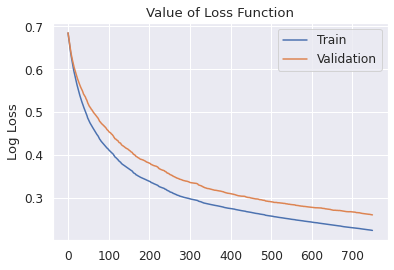

In [371]:
# plot log loss
import matplotlib.pyplot as pyplot
fig, ax = pyplot.subplots()
ax.plot(r['validation_0']['logloss'], label='Train')
ax.plot(r['validation_1']['logloss'], label='Validation')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('Value of Loss Function')
pyplot.show()

# Meta Feature Importances

Image size seems pretty important on our model, but don't forget this can be misleading for final scoring. Don't forget about missing image sizes in test set and size correlation with targets in train data!

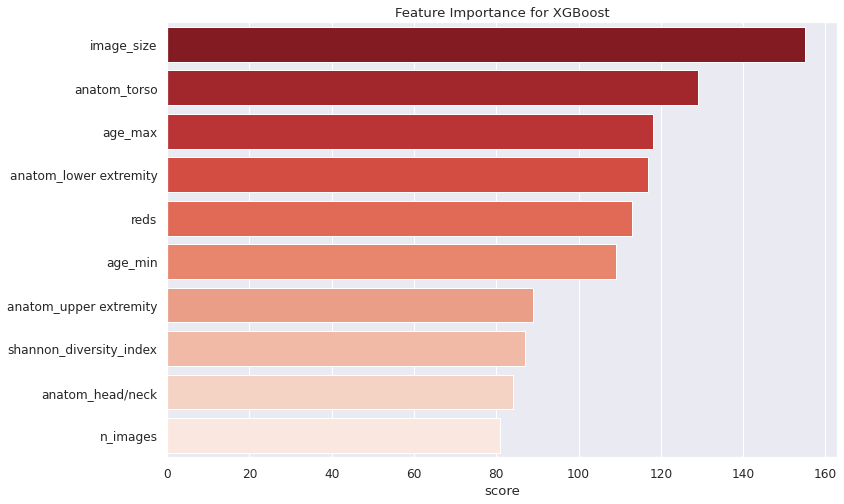

In [372]:
# finding feature importances and creating new dataframe basen on them

feature_importance = xg.get_booster().get_score(importance_type='weight')

keys = list(feature_importance.keys())
values = list(feature_importance.values())

importance = pd.DataFrame(data=values, index=keys,
                          columns=['score']).sort_values(by='score',
                                                         ascending=False)
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(x=importance.score.iloc[:10],
            y=importance.index[:10],
            orient='h',
            palette='Reds_r')
ax.set_title('Feature Importance for XGBoost')
plt.show()

Best Threshold=0.356849, G-Mean=0.773


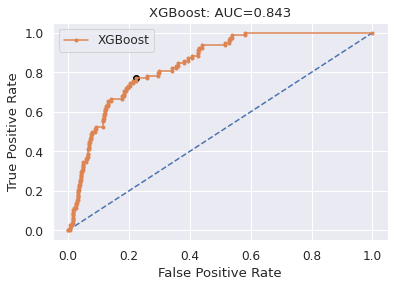

In [373]:
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot
from sklearn.metrics import roc_curve, roc_auc_score
from numpy import argmax
from numpy import sqrt
from numpy import arange
from sklearn.metrics import f1_score

# predicting on test set
predictions = xg.predict_proba(test_n)[:, 1]

precision, recall, thresholds = precision_recall_curve(testy['target'], predictions)
fpr, tpr, thresholds = roc_curve(testy['target'], predictions)
ns_auc = roc_auc_score(testy['target'], predictions)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--')#, label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='XGBoost')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black')#, label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.title('XGBoost: AUC=%.3f' % (ns_auc))
# show the plot
pyplot.show()

----- XGBoost -----
              precision    recall  f1-score   support

           0       0.99      0.78      0.87      4276
           1       0.06      0.77      0.11        78

    accuracy                           0.78      4354
   macro avg       0.53      0.77      0.49      4354
weighted avg       0.98      0.78      0.86      4354



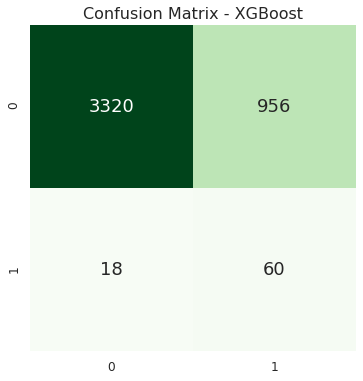

In [374]:
from sklearn.metrics import cohen_kappa_score, f1_score, confusion_matrix, auc, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
print("----- XGBoost -----")
fpr, tpr, _ = roc_curve(testy['target'], predictions)
roc_auc = auc(fpr, tpr)

from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.metrics import classification_report

predictionsXGB = np.where(predictions >= thresholds[ix], 1, 0)
confusion = confusion_matrix(testy['target'],predictionsXGB )
plt.figure(figsize=(6,6))
sns.heatmap(confusion, cbar=False, annot=True, fmt="g", annot_kws={'size':18}, square=True, cmap="Greens")
plt.title('Confusion Matrix - XGBoost', size=16)

print(classification_report(testy['target'], predictionsXGB))


In [375]:
from sklearn.metrics import confusion_matrix

def get_confusion_matrix(y_true, y_pred):
    transdict = {1: "malignant", 0: "benign"}
    y_t = np.array([transdict[x] for x in y_true])
    y_p = np.array([transdict[x] for x in y_pred])
    
    labels = ["benign", "malignant"]
    index_labels = ["actual benign", "actual malignant"]
    col_labels = ["predicted benign", "predicted malignant"]
    confusion = confusion_matrix(y_t, y_p, labels=labels)
    confusion_df = pd.DataFrame(confusion, index=index_labels, columns=col_labels)
    for n in range(2):
        confusion_df.iloc[n] = confusion_df.iloc[n] / confusion_df.sum(axis=1).iloc[n]
    return confusion_df

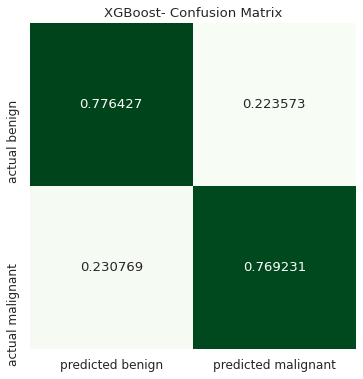

In [376]:
confusion = get_confusion_matrix(testy['target'],predictionsXGB)
plt.figure(figsize=(6,6))
plt.title('XGBoost- Confusion Matrix')
sns.heatmap(confusion, cbar=False, annot=True, fmt="g", square=True, cmap="Greens");

In [377]:
# creating submission df
meta_df_7 = pd.DataFrame(columns=['image_name', 'target'])
# assigning predictions on submission df
meta_df_7['image_name'] = test_image_names
meta_df_7['target'] = predictions


# Machine Learning to Neural Networks

This part we gonna train more complicated models by using images themselves. For this part I was inspired by AgentAuers's 'Incredible TPUs' [here](https://www.kaggle.com/agentauers/incredible-tpus-finetune-effnetb0-b6-at-once). It's a great notebook and you should check that, again thanks for AgentAuers for letting me use some of his code as baseline for this part of the notebook! Also thanks to Chris Deotte for great datasets with tfrecords! 

We start by importing neccesary packages and setting random seed.

In [378]:
DEVICE = "TPU"
BASEPATH = "../input/siim-isic-melanoma-classification"

In [379]:
# Setting TPU as main device for training, if you get warnings while working with tpu's ignore them.

if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if DEVICE != "TPU":
    print("Using default strategy for CPU and single GPU")
    strategy = tf.distribute.get_strategy()

if DEVICE == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    
print("REPLICAS: ", strategy.num_replicas_in_sync)
AUTO = tf.data.experimental.AUTOTUNE


connecting to TPU...
Running on TPU  grpc://10.0.0.2:8470
initializing  TPU ...
TPU initialized
REPLICAS:  8


In [380]:
# Configuration
EPOCHS = 20
BATCH_SIZE = 8 * strategy.num_replicas_in_sync
IMAGE_SIZE = [128, 128]

In [381]:
GCS_PATH = KaggleDatasets().get_gcs_path('melanoma-128x128')
TRAINING_FILENAMES, TEST_FILENAMES =  np.array(train_test_split(tf.io.gfile.glob(GCS_PATH + '/train*.tfrec'), test_size=0.1, random_state=42))
TRAINING_FILENAMES, VALIDATION_FILENAMES =  np.array(train_test_split(TRAINING_FILENAMES, test_size=0.2, random_state=42))


In [382]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        #"class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
        "target": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    
    #label = tf.cast(example['class'], tf.int32)
    label = tf.cast(example['target'], tf.float32)
    print(example['target'])
    print("label", label)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "image_name": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['image_name']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def data_augment(image, label):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_hue(image, 0.01)
    image = tf.image.random_saturation(image, 0.7, 1.3)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_brightness(image, 0.1)
    return image, label   

def get_training_dataset():
    print(TRAINING_FILENAMES)
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True, ordered=True)
    print("after load", dataset)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=True):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_test_dataset(labeled=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=labeled, ordered=True)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
print('Dataset: {} training images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_TEST_IMAGES))

Dataset: 21800 training images, 4354 unlabeled test images


In [383]:
print("Training Files", count_data_items(TRAINING_FILENAMES))
print("Validation Files", count_data_items(VALIDATION_FILENAMES))
print("Testing Files", count_data_items(TEST_FILENAMES))

Training Files 21800
Validation Files 6538
Testing Files 4354


In [384]:
raw_dataset = get_training_dataset()
image_batch, label_batch = next(iter(raw_dataset))

['gs://kds-a98f85b230b6351e32bce34528489cc14bc2ae2e29758888c8d10be0/train07-2174.tfrec', 'gs://kds-a98f85b230b6351e32bce34528489cc14bc2ae2e29758888c8d10be0/train01-2185.tfrec', 'gs://kds-a98f85b230b6351e32bce34528489cc14bc2ae2e29758888c8d10be0/train05-2171.tfrec', 'gs://kds-a98f85b230b6351e32bce34528489cc14bc2ae2e29758888c8d10be0/train13-2186.tfrec', 'gs://kds-a98f85b230b6351e32bce34528489cc14bc2ae2e29758888c8d10be0/train06-2175.tfrec', 'gs://kds-a98f85b230b6351e32bce34528489cc14bc2ae2e29758888c8d10be0/train02-2193.tfrec', 'gs://kds-a98f85b230b6351e32bce34528489cc14bc2ae2e29758888c8d10be0/train04-2167.tfrec', 'gs://kds-a98f85b230b6351e32bce34528489cc14bc2ae2e29758888c8d10be0/train12-2198.tfrec', 'gs://kds-a98f85b230b6351e32bce34528489cc14bc2ae2e29758888c8d10be0/train08-2177.tfrec', 'gs://kds-a98f85b230b6351e32bce34528489cc14bc2ae2e29758888c8d10be0/train14-2174.tfrec']
Tensor("ParseSingleExample/ParseExample/ParseExampleV2:1", shape=(), dtype=int64)
label Tensor("Cast_1:0", shape=(), dt

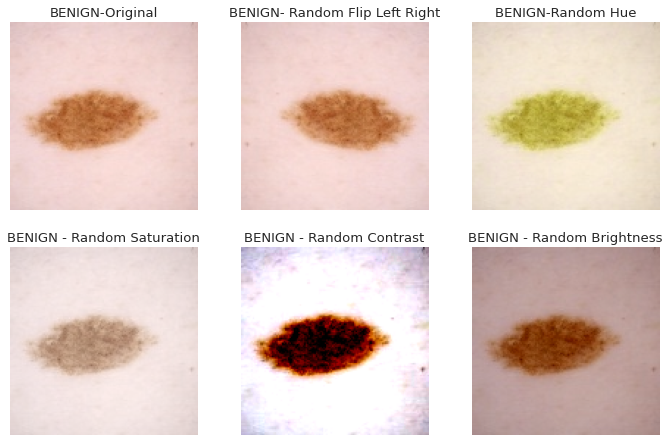

In [385]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(20, 20))
    for n in range(1):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("MALIGNANT-Original")
        else:
            plt.title("BENIGN-Original")
        plt.axis("off")
        
        ax = plt.subplot(5, 5, n + 2)
        plt.imshow(tf.image.random_flip_left_right(image_batch[n]))
        if label_batch[n]:
            plt.title("MALIGNANT-Random Flip Left Right")
        else:
            plt.title("BENIGN- Random Flip Left Right")
        plt.axis("off")
        
        ax = plt.subplot(5, 5, n + 3)
        plt.imshow(tf.image.random_hue(image_batch[n], 0.2))
        if label_batch[n]:
            plt.title("MALIGNANT-Random Hue")
        else:
            plt.title("BENIGN-Random Hue")
        plt.axis("off")
        
        ax = plt.subplot(5, 5, n +6)
        plt.imshow(tf.image.random_saturation(image_batch[n], 0.1, 1.3))
        if label_batch[n]:
            plt.title("MALIGNANT- Random Saturation")
        else:
            plt.title("BENIGN - Random Saturation")
        plt.axis("off")
        
        ax = plt.subplot(5, 5, n +7)
        plt.imshow(tf.image.random_contrast(image_batch[n], 0, 5))
        if label_batch[n]:
            plt.title("MALIGNANT- Random Contrast")
        else:
            plt.title("BENIGN - Random Contrast")
        plt.axis("off")
        
        ax = plt.subplot(5, 5, n +8)
        plt.imshow(tf.image.random_brightness(image_batch[n], 0.4))
        if label_batch[n]:
            plt.title("MALIGNANT- Random Brightness")
        else:
            plt.title("BENIGN - Random Brightness")
        plt.axis("off")

show_batch(image_batch, label_batch)

In [386]:
def lrfn(epoch):
    LR_START          = 0.000005
    LR_MAX            = 0.000020 * strategy.num_replicas_in_sync
    LR_MIN            = 0.000001
    LR_RAMPUP_EPOCHS = 5
    LR_SUSTAIN_EPOCHS = 0
    LR_EXP_DECAY = .8
    
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr

In [387]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Activation, Dropout
from tensorflow.keras.regularizers import l2
#reg_l2 = 0.001

In [388]:
# image size:
# choose one between 256, 384, 512, 768
tfrec_shape = 128

# competition data:
# choose between "2020" (only 2020 competition data) or "2019-2020" (2020 + 2019 competition data, including 2017 and 2018)
comp_data = "2020"

# model weights
model_weights = 'imagenet'

In [389]:
# BUILD MODEL

def get_model(model):
    
    model_input = tf.keras.Input(shape=(*IMAGE_SIZE, 3), name='imgIn')
    dummy = tf.keras.layers.Lambda(lambda x:x)(model_input)
    outputs = []

    constructor = getattr(efn, model)
    x = constructor(include_top=False, weights=model_weights, input_shape=(*IMAGE_SIZE, 3), pooling='avg')(dummy)
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    outputs.append(x)
    
    model = tf.keras.Model(model_input, outputs, name='aNetwork')
    model.summary()
    
    return model

In [390]:
# COMPILE MODEL

def compile_new_model(model):
    with strategy.scope():
        model = get_model(model)
     
        #losses = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.05)
        losses = tfa.losses.SigmoidFocalCrossEntropy(gamma = 2.0, alpha = 0.25)
        
        model.compile(
            optimizer ='adam',
            loss = losses,
            metrics = [tf.keras.metrics.BinaryAccuracy()]) # metrics = ['accuracy']
        
    return model

In [391]:
class_weight = {0: 1,
                1: 25}
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)
model_B6 = compile_new_model('EfficientNetB6')
print("\n Begin Training Models")
history_B6 = model_B6.fit(get_training_dataset(),class_weight=class_weight, verbose=1, steps_per_epoch=STEPS_PER_EPOCH, epochs = 20,callbacks=[lr_schedule], validation_data = get_validation_dataset())
print("\n Done Training model_B6 \n")

Model: "aNetwork"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
imgIn (InputLayer)           [(None, 128, 128, 3)]     0         
_________________________________________________________________
lambda_5 (Lambda)            (None, 128, 128, 3)       0         
_________________________________________________________________
efficientnet-b6 (Functional) (None, 2304)              40960136  
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 2305      
Total params: 40,962,441
Trainable params: 40,738,009
Non-trainable params: 224,432
_________________________________________________________________

 Begin Training Models
['gs://kds-a98f85b230b6351e32bce34528489cc14bc2ae2e29758888c8d10be0/train07-2174.tfrec', 'gs://kds-a98f85b230b6351e32bce34528489cc14bc2ae2e29758888c8d10be0/train01-2185.tfrec', 'gs://kds-a98f85b230b6351e32bce345284

----- Efficient Net -----


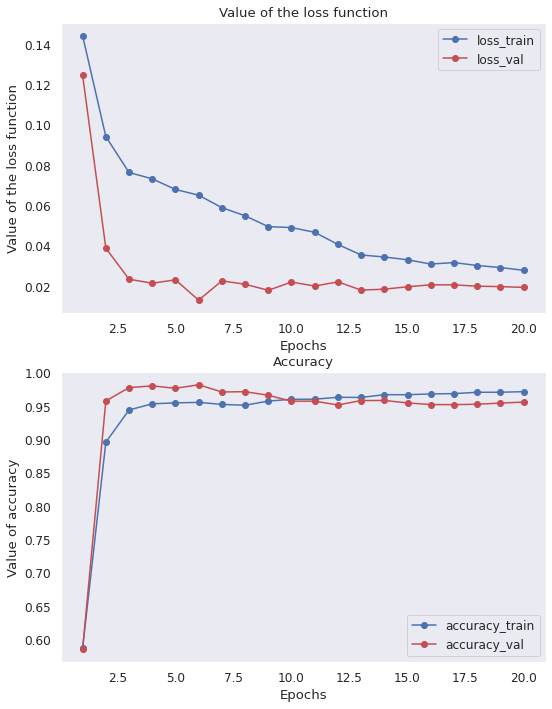

In [411]:
import matplotlib.pyplot as plt
print("----- Efficient Net -----")
fig, axs = plt.subplots(2, 1, figsize=(8, 10))
plt.tight_layout(pad=2)
fig.subplots_adjust(hspace = .2, wspace=.2)
axs = axs.ravel()
loss = history_B6.history['loss']
loss_val = history_B6.history['val_loss']
epochs = range(1, len(loss)+1)
axs[0].plot(epochs, loss, '-bo', label='loss_train')
axs[0].plot(epochs, loss_val, '-ro', label='loss_val')
axs[0].set_title('Value of the loss function')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Value of the loss function')
axs[0].legend()
axs[0].grid()
acc = history_B6.history['binary_accuracy']
acc_val = history_B6.history['val_binary_accuracy']
axs[1].plot(epochs, acc, '-bo', label='accuracy_train')
axs[1].plot(epochs, acc_val, '-ro', label='accuracy_val')
axs[1].set_title('Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Value of accuracy')
axs[1].legend()
axs[1].grid()
plt.show()



In [393]:
test = tf.data.TFRecordDataset(TEST_FILENAMES, num_parallel_reads=AUTO)
mappedTest = test.map(read_labeled_tfrecord)
print(mappedTest)
labels = []
for ele in mappedTest:
    labels.append(ele[1].numpy())    
#     break
# labels

Tensor("ParseSingleExample/ParseExample/ParseExampleV2:1", shape=(), dtype=int64)
label Tensor("Cast_1:0", shape=(), dtype=float32)
<MapDataset shapes: ((128, 128, 3), ()), types: (tf.float32, tf.float32)>


In [394]:

test_ds = get_test_dataset(True)
print('Computing predictions...')
test_images_ds = test_ds.map(lambda image, idnum: image)

# probabilitiesRN = modelRN.predict(test_images_ds)
probabilities7 = model_B6.predict(test_images_ds, verbose=1)
# probabilitiesV3 = modelIV3.predict(test_images_ds)

Tensor("ParseSingleExample/ParseExample/ParseExampleV2:1", shape=(), dtype=int64)
label Tensor("Cast_1:0", shape=(), dtype=float32)
Computing predictions...
69/69 [==============================] - 17s 91ms/step


In [395]:
max(probabilities7)

array([0.8506998], dtype=float32)

In [396]:
from sklearn.metrics import confusion_matrix

def get_confusion_matrix(y_true, y_pred):
    transdict = {1: "malignant", 0: "benign"}
    y_t = np.array([transdict[x] for x in y_true])
    y_p = np.array([transdict[x] for x in y_pred])
    
    labels = ["benign", "malignant"]
    index_labels = ["actual benign", "actual malignant"]
    col_labels = ["predicted benign", "predicted malignant"]
    confusion = confusion_matrix(y_t, y_p, labels=labels)
    confusion_df = pd.DataFrame(confusion, index=index_labels, columns=col_labels)
    for n in range(2):
        confusion_df.iloc[n] = confusion_df.iloc[n] / confusion_df.sum(axis=1).iloc[n]
    return confusion_df

----- Efficient Net -----
Best Threshold=0.215762, G-Mean=0.792


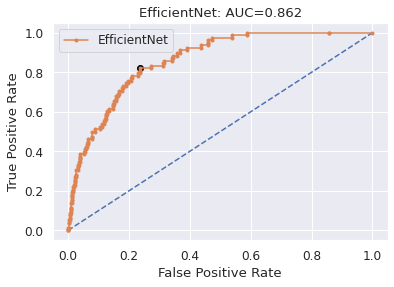

[[3265 1011]
 [  14   64]]


Text(0.5, 1.0, 'Confusion Matrix - EfficientNet')

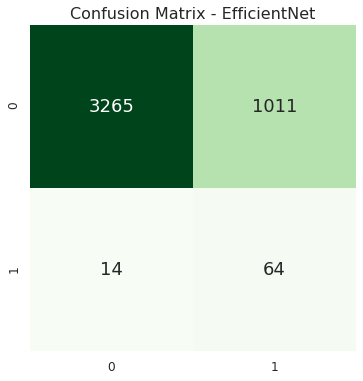

In [397]:
from sklearn.metrics import cohen_kappa_score, f1_score, confusion_matrix, auc, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
print("----- Efficient Net -----")
precision, recall, thresholds = precision_recall_curve(labels, probabilities7)
fpr, tpr, thresholds = roc_curve(labels, probabilities7)
ns_auc = roc_auc_score(labels, probabilities7)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--')#, label='No Model')
pyplot.plot(fpr, tpr, marker='.', label='EfficientNet')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black')#, label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.title('EfficientNet: AUC=%.3f' % (ns_auc))
# show the plot
pyplot.show()

predictionsEN = np.where(probabilities7 >= thresholds[ix], 1, 0)
confusion = confusion_matrix(labels,predictionsEN )
print(confusion)
plt.figure(figsize=(6,6))
sns.heatmap(confusion, cbar=False, annot=True, fmt="g", annot_kws={'size':18}, square=True, cmap="Greens")
plt.title('Confusion Matrix - EfficientNet', size=16)




In [398]:
##flattening the list to use in the confusion matrix percentages##

h =(predictionsEN.tolist())

def flatten_list(_2d_list):
    flat_list = []
    # Iterate through the outer list
    for element in _2d_list:
        if type(element) is list:
            # If the element is of type list, iterate through the sublist
            for item in element:
                flat_list.append(item)
        else:
            flat_list.append(element)
    return flat_list

k = flatten_list(h)

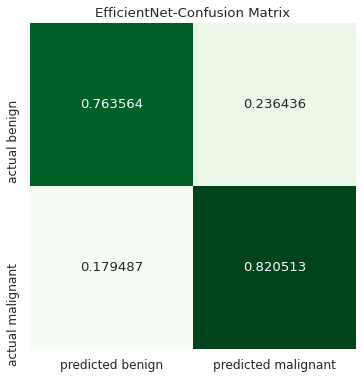

In [399]:
confusion = get_confusion_matrix(labels,k)
plt.figure(figsize=(6,6))
plt.title('EfficientNet-Confusion Matrix')
sns.heatmap(confusion, cbar=False, annot=True, fmt="g", square=True, cmap="Greens");

In [400]:
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

print(classification_report(labels, predictionsEN))

              precision    recall  f1-score   support

         0.0       1.00      0.76      0.86      4276
         1.0       0.06      0.82      0.11        78

    accuracy                           0.76      4354
   macro avg       0.53      0.79      0.49      4354
weighted avg       0.98      0.76      0.85      4354



In [401]:
#tf.keras.utils.plot_model(model_B6,show_shapes=True)

In [402]:
test_2 = get_test_dataset(True)
test_3 = get_test_dataset(False)

# test_images_ds = test_3.map(lambda image, idnum: image)
test_ids_ds = test_3.map(lambda image, image_name: image_name).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U') # all in one batch


Tensor("ParseSingleExample/ParseExample/ParseExampleV2:1", shape=(), dtype=int64)
label Tensor("Cast_1:0", shape=(), dtype=float32)


In [403]:
# pred_dfRN = pd.DataFrame({'image_name': test_ids, 'target': np.concatenate(probabilitiesRN)})
pred_df7 = pd.DataFrame({'image_name': test_ids, 'target': np.concatenate(probabilities7)})
# pred_dfV3 = pd.DataFrame({'image_name': test_ids, 'target': np.concatenate(probabilitiesV3)})

pred_df7.head()

,image_name,target
0,ISIC_0076262,0.141138
1,ISIC_0074268,0.021427
2,ISIC_0082543,0.043288
3,ISIC_0075663,0.283233
4,ISIC_0089401,0.040764


In [404]:
#ISIC_0178235 checks

print(meta_df_7.loc[meta_df_7['image_name'] == 'ISIC_0076742'])
print(pred_df7.loc[pred_df7['image_name'] == 'ISIC_0076742'])

      image_name    target
11  ISIC_0076742  0.108736
     image_name    target
5  ISIC_0076742  0.117571


In [405]:
#checks
test_chk = pd.merge(meta_df_7, pred_df7, on='image_name')
print(meta_df_7.dtypes)
print(pred_df7.dtypes)
print(test_chk)
                            
                          
                          

image_name     object
target        float32
dtype: object
image_name     object
target        float32
dtype: object
        image_name  target_x  target_y
0     ISIC_0074268  0.010681  0.021427
1     ISIC_0075663  0.307374  0.283233
2     ISIC_0076262  0.025987  0.141138
3     ISIC_0076742  0.108736  0.117571
4     ISIC_0082543  0.018413  0.043288
...            ...       ...       ...
4349  ISIC_9997614  0.323928  0.164408
4350  ISIC_9998582  0.039471  0.289703
4351  ISIC_9998937  0.185668  0.063614
4352  ISIC_9999320  0.020293  0.002563
4353  ISIC_9999666  0.181792  0.117124

[4354 rows x 3 columns]


In [406]:
ensemble1 = (test_chk['target_x']* 0.4 + test_chk['target_y']*0.6)
ensemble_img1 = test_chk['image_name']
ensemble_sub1 = pd.concat([ensemble_img1, ensemble1], axis = 1)
ensemble_sub1.columns = ['image_name', 'probability']
ensemble_sub1.head()

,image_name,probability
0,ISIC_0074268,0.017129
1,ISIC_0075663,0.292889
2,ISIC_0076262,0.095078
3,ISIC_0076742,0.114037
4,ISIC_0082543,0.033338


Best Threshold=0.291274, G-Mean=0.826


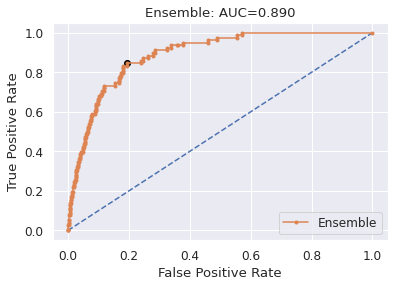

In [407]:
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot
from sklearn.metrics import roc_curve
from numpy import argmax
from numpy import sqrt
from numpy import arange
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

precision, recall, thresholds = precision_recall_curve(testy['target'], ensemble_sub1['probability'])
fpr, tpr, thresholds = roc_curve(testy['target'], ensemble_sub1['probability'])
ns_auc = roc_auc_score(testy['target'], ensemble_sub1['probability'])
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--')#, label='No Model')
pyplot.plot(fpr, tpr, marker='.', label='Ensemble')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black')#, label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.title('Ensemble: AUC=%.3f' % (ns_auc))
# show the plot
pyplot.show()

              precision    recall  f1-score   support

           0       1.00      0.81      0.89      4276
           1       0.07      0.85      0.14        78

    accuracy                           0.81      4354
   macro avg       0.54      0.83      0.51      4354
weighted avg       0.98      0.81      0.88      4354

[[3450  826]
 [  12   66]]


Text(0.5, 1.0, 'Confusion Matrix - Ensemble')

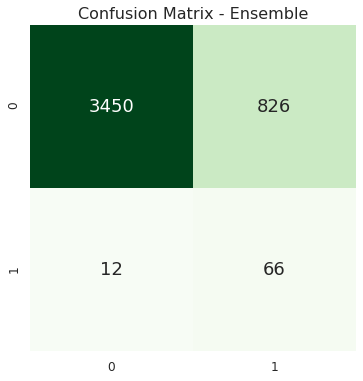

In [408]:
from sklearn.metrics import classification_report
predictionsEN_Fin = np.where(ensemble_sub1['probability'] >= thresholds[ix], 1, 0)
print(classification_report(testy['target'], predictionsEN_Fin))
confusion = confusion_matrix(testy['target'],predictionsEN_Fin )
print(confusion)
plt.figure(figsize=(6,6))
sns.heatmap(confusion, cbar=False, annot=True, fmt="g", annot_kws={'size':18}, square=True, cmap="Greens")
plt.title('Confusion Matrix - Ensemble', size=16)

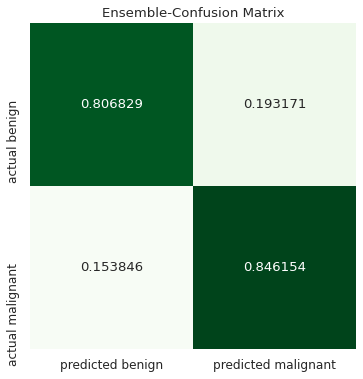

In [409]:
confusion = get_confusion_matrix(testy['target'],predictionsEN_Fin)
plt.figure(figsize=(6,6))
plt.title('Ensemble-Confusion Matrix')
sns.heatmap(confusion, cbar=False, annot=True, fmt="g", square=True, cmap="Greens");